In [12]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn import neighbors, ensemble, tree, metrics
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib notebook

package_dir = os.getcwd()

print(package_dir)

C:\Users\Sebastian\Programming\Bachelorthtesis


In [ ]:
df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    # make pollutant a column for better memory usage
    clean = clean.pivot(columns='AirPollutant')
    df = pd.concat([df, clean])

print('\nFinished Loading')
print('Merging')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']
df = df.sort_index()
df = df.groupby(level=[0,1]).first()


print('Finished merging')

In [5]:
df = pd.DataFrame()

for file in glob.glob('res/*2013_timeseries.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4,14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    pivoted = clean.pivot(columns='AirPollutant')
    
    df = pd.concat([df, pivoted])

# make pollutant a column for better memory usage
#df = df.pivot(columns='AirPollutant')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']

df = df.sort_index()
df = df.groupby(level=[0,1]).first()

df = df.interpolate()

In [ ]:
df.loc['DESN025'].Concentration.count()

<IPython.core.display.Javascript object>


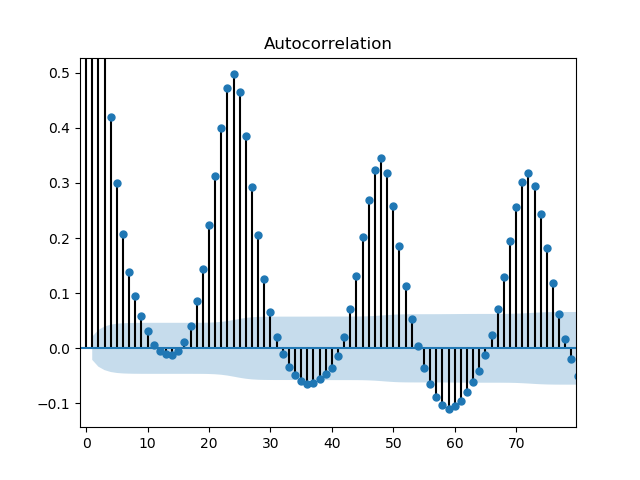

In [7]:
acf = tsaplots.plot_acf(df.loc['DESN025'].Concentration.NO, lags=700)

In [ ]:
plt.figure(figsize=(9, 4))

pd.plotting.autocorrelation_plot(df.loc['DESN025'].Concentration.NO)
plt.show()

<IPython.core.display.Javascript object>


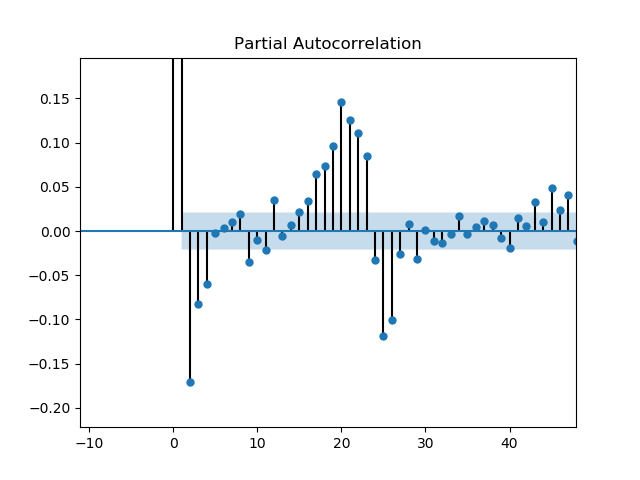

In [8]:
pacf = tsaplots.plot_pacf(df.loc['DESN025'].Concentration.NO, lags=700)

In [ ]:
lagged = pd.DataFrame()

for i in range(1,8):
    lagged['lag {0}d'.format(i)] = df.loc['DESN025'].Concentration.NO.shift(i, freq='H')
    
lagged = lagged.interpolate()

lagged

In [58]:
asdf = '2013-12-10'
end = '2013-10-01'
x_train = lagged[end:asdf].interpolate()
y_train = df.loc['DESN025'].Concentration.NO[end:asdf]
index_train = df.loc['DESN025'].Concentration.NO[end:asdf].index.values

x_test = lagged[asdf:].iloc[:-1]
y_test = df.loc['DESN025'].Concentration.NO[asdf:]
index_test = df.loc['DESN025'].Concentration.NO[asdf:].index.values

In [ ]:
# plt.figure(figsize=(20,10))
# #############################################################################
# Fit regression model
n_neighbors = 10

plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']
solutions = {}

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn_model = knn.fit(x_train, y_train)
    y_ = knn_model.predict(x_test)
    solutions['knn %s' % weights] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label=weights)
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor")
    print('{0} mae: {1}\tmse: {2}'.format(weights, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

In [ ]:
plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']

########################################################################
for i, depth in enumerate([2, 3, 5, 10, 15]):
    dtree = tree.DecisionTreeRegressor(max_depth=depth)
    dtree_model = dtree.fit(x_train, y_train)
    y_ = dtree_model.predict(x_test)
    solutions['dtree depth %s' % depth] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label='depth {0}'.format(depth))
    plt.axis('tight')
    plt.legend()
    plt.title("DTreeRegression")
    print('{0} mae: {1}\tmse: {2}'.format(depth, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

In [ ]:
plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']

########################################################################
for i, estimators in enumerate([5, 10, 20, 50, 100]):
    rforest = ensemble.RandomForestRegressor(n_estimators=estimators)
    rforest_model = rforest.fit(x_train, y_train)
    y_ = rforest_model.predict(x_test)
    solutions['rforest estimators {0}'.format(estimators)] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label='{0} estimators'.format(estimators))
    plt.axis('tight')
    plt.legend()
    plt.title('Random Forest Regression')
    print('{0} mae: {1}\tmse: {2}'.format(estimators, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

In [ ]:
## not yet working or running way, way, way too long

arima = ARIMA(df.loc['DESN025'].Concentration.NO, order=(25,1,0))
arima_model = arima.fit(disp=0)
print(arima_model.summary())
# plot residual errors
residuals = DataFrame(arima_model.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

D:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<IPython.core.display.Javascript object>


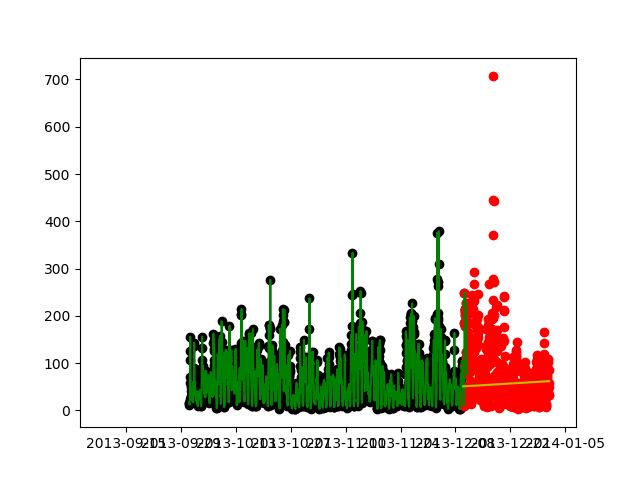

In [59]:
ets = ExponentialSmoothing(y_train, trend='add')
ets_model = ets.fit()
ets_forecast = ets_model.forecast(len(y_test))

plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')
plt.plot(index_train, ets_model.fittedvalues, c='g', label='fit')
plt.plot(index_test, ets_forecast, c='y', label='forecast')